# Прогнозирование объема кредитов МСП с помощью ARIMA

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
import itertools
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math
import statsmodels.api as sm
from openpyxl import load_workbook
from statsmodels.tsa.arima.model import ARIMA 

from parser.gdp import get_gdp_dataframe
from data_transform.transform_df import transform_df_to_format
from parser.loans_volume_msp import get_loans_volume_msp_df

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit

from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.boxcox import LogTransformer

In [2]:
warnings.filterwarnings("ignore")

Вспомогательные функции:

In [3]:
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)
    
def mape( actual , pred ): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))* 100

## Подготовка датафрейма 

In [135]:
df = transform_df_to_format(get_loans_volume_msp_df(2019, 2024, spikes_remove=False))
df

,msp_loans_volume,month_n,year,Отчетный период
0,452992.0,1,2019,Январь 2019 г.
1,482114.0,2,2019,Февраль 2019 г.
2,604402.0,3,2019,Март 2019 г.
3,686986.0,4,2019,Апрель 2019 г.
4,585284.0,5,2019,Май 2019 г.
...,...,...,...,...
59,1854476.0,12,2023,Декабрь 2023 г.
60,935130.0,1,2024,Январь 2024 г.
61,1216737.0,2,2024,Февраль 2024 г.
62,1524903.0,3,2024,Март 2024 г.


In [187]:
df_spike_remove = transform_df_to_format(get_loans_volume_msp_df(2019, 2024, spikes_remove=True))
df_spike_remove

,msp_loans_volume,month_n,year,Отчетный период
0,4.028862e+05,1,2019,Январь 2019 г.
1,4.208281e+05,2,2019,Февраль 2019 г.
2,7.157937e+05,3,2019,Март 2019 г.
3,6.368802e+05,4,2019,Апрель 2019 г.
4,5.239981e+05,5,2019,Май 2019 г.
...,...,...,...,...
59,1.437707e+06,12,2023,Декабрь 2023 г.
60,1.221420e+06,1,2024,Январь 2024 г.
61,1.155451e+06,2,2024,Февраль 2024 г.
62,1.636295e+06,3,2024,Март 2024 г.


In [188]:
# Для постороения прогноза по скорректированным данным запустить данную строчку
df = df_spike_remove

In [189]:
# Извлекаем год из столбца "Отчетный период"
df['date'] = df['Отчетный период'].str.extract(r'(\d{4})').astype(int)

# Формируем новый столбец "Дата" в формате YYYY-MM
df['date'] = df['date'].astype(str) + '-' + df['month_n'].astype(str)
df['date'] = pd.to_datetime(df['date'])

# Удаляем временные столбцы
df = df[['date', 'msp_loans_volume']]
df = df.reset_index()
df = df.drop('index', axis = 1)
df

,date,msp_loans_volume
0,2019-01-01,4.028862e+05
1,2019-02-01,4.208281e+05
2,2019-03-01,7.157937e+05
3,2019-04-01,6.368802e+05
4,2019-05-01,5.239981e+05
...,...,...
59,2023-12-01,1.437707e+06
60,2024-01-01,1.221420e+06
61,2024-02-01,1.155451e+06
62,2024-03-01,1.636295e+06


Посмотрим на данные:

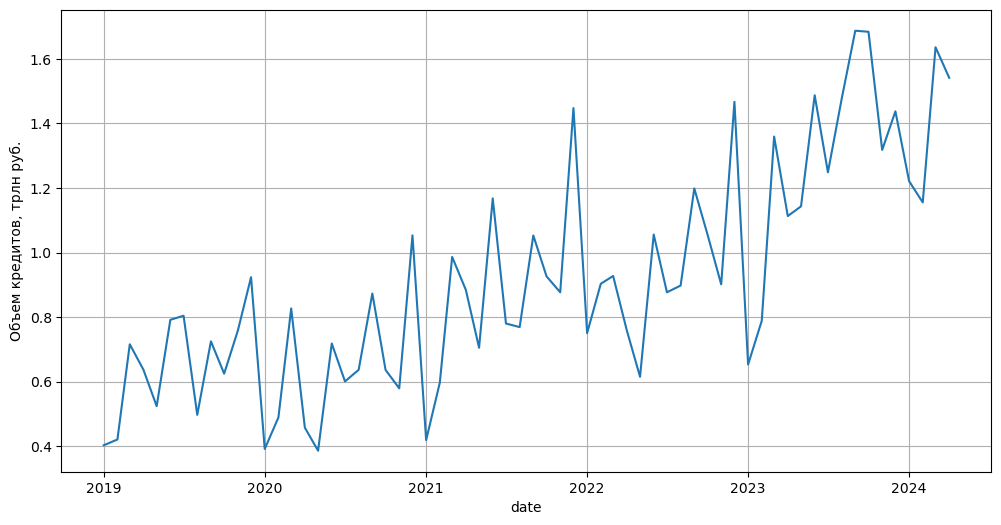

In [190]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['msp_loans_volume'].values/ 1e6)
plt.xlabel('date')
plt.ylabel('Объем кредитов, трлн руб.')
plt.grid(True)
plt.show()

Посмотрим на декомпозицию

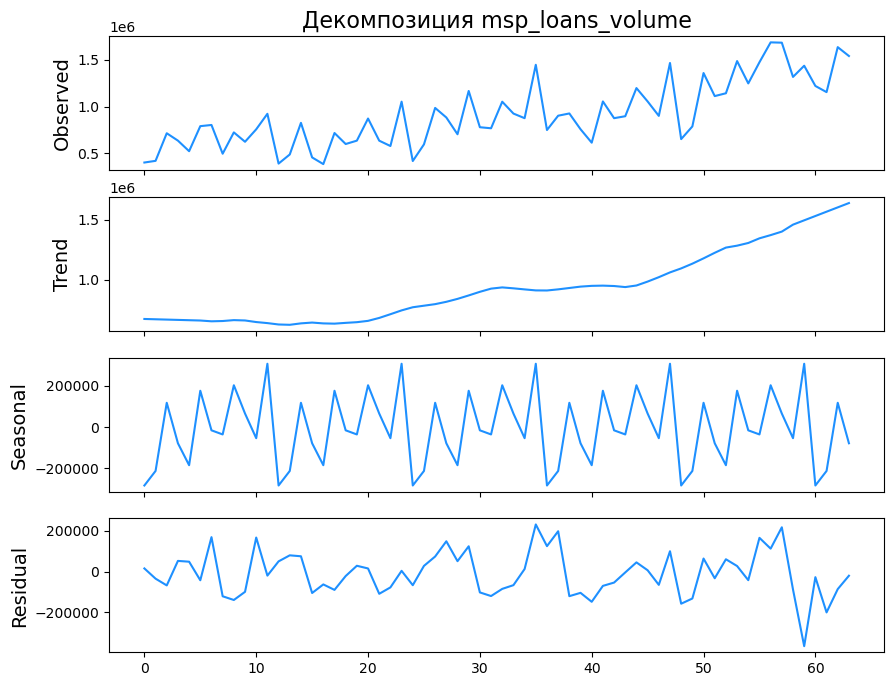

In [191]:
# Декомпозиция
decomp = seasonal_decompose(df['msp_loans_volume'], period=12, model='additive', extrapolate_trend='freq')

fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(10,8))
res = decomp

ax[0].set_title('Декомпозиция {}'.format('msp_loans_volume'), fontsize=16)
res.observed.plot(ax=ax[0], legend=False, color='dodgerblue')
ax[0].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1], legend=False, color='dodgerblue')
ax[1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2], legend=False, color='dodgerblue')
ax[2].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3], legend=False, color='dodgerblue')
ax[3].set_ylabel('Residual', fontsize=14)

plt.show()

Разделим данные на train и test выборки:

In [192]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size
print("train_size = ", train_size)
print("test_size = ", test_size)

train_size =  54
test_size =  10


In [193]:
split_date = df['date'].iloc[train_size]
split_date

Timestamp('2023-07-01 00:00:00')

In [194]:
# разделение данных на тестовые и тренировочные
train = df[df['date']<split_date]
test = df[df['date']>=split_date]

In [195]:
train # тренировочная выборка

,date,msp_loans_volume
0,2019-01-01,4.028862e+05
1,2019-02-01,4.208281e+05
2,2019-03-01,7.157937e+05
3,2019-04-01,6.368802e+05
4,2019-05-01,5.239981e+05
5,2019-06-01,7.916397e+05
6,2019-07-01,8.042662e+05
7,2019-08-01,4.970841e+05
8,2019-09-01,7.249067e+05
9,2019-10-01,6.248062e+05


In [196]:
test # тестовая выборка

,date,msp_loans_volume
54,2023-07-01,1.248651e+06
55,2023-08-01,1.475003e+06
56,2023-09-01,1.687433e+06
57,2023-10-01,1.684164e+06
58,2023-11-01,1.318051e+06
59,2023-12-01,1.437707e+06
60,2024-01-01,1.221420e+06
61,2024-02-01,1.155451e+06
62,2024-03-01,1.636295e+06
63,2024-04-01,1.541567e+06


In [197]:
# Делаем из датафреймов серии

trn_ser = train.copy()
trn_ser.set_index(keys='date', drop=True, inplace=True)
trn_ser = trn_ser.squeeze(axis=1)

tst_ser = test.copy()
tst_ser.set_index(keys='date', drop=True, inplace=True)
tst_ser = tst_ser.squeeze(axis=1)

## Стационарность

(0.6076242670042649, 0.9878020543534624, 11, 42, {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}, 1133.7312069821921)


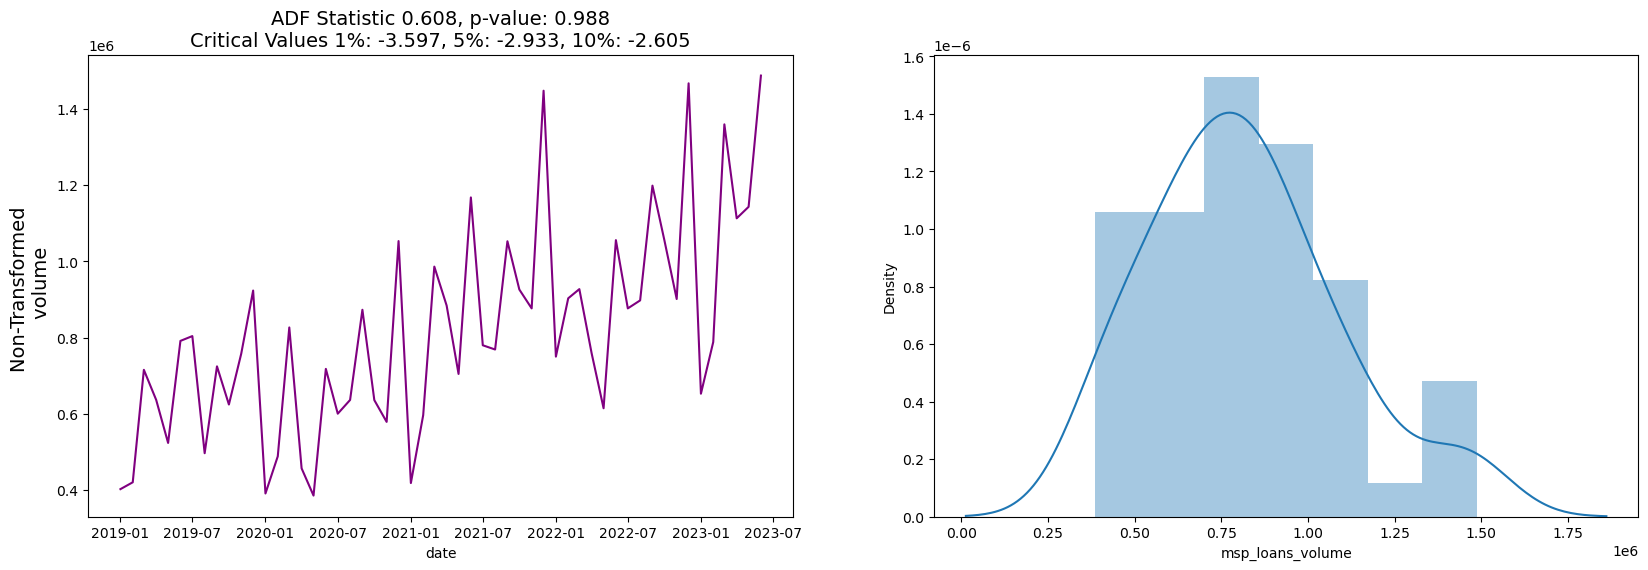

In [198]:
print(adfuller(train['msp_loans_volume'])) # Данные не стационарны

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(train['msp_loans_volume'], 'Non-Transformed \n volume', ax[0])
sns.distplot(train['msp_loans_volume'], ax=ax[1])

plt.show()

Трансформируем данные:

In [199]:
transformer_1 = LogTransformer()
trn_transform = transformer_1.fit_transform(trn_ser) # логорифмируем
 
adfuller(trn_transform)# Данные не стационарны

(0.2836111339634128,
 0.9765799537856866,
 11,
 42,
 {'1%': -3.596635636000432,
  '5%': -2.933297331821618,
  '10%': -2.6049909750566895},
 -3.5773193750652013)

In [200]:
transformer_2 = Differencer(lags=[1, 12])
trn_transform = transformer_2.fit_transform(trn_transform) # дифференцируем

adfuller(trn_transform)# Данные стационарны!

(-5.664660818170504,
 9.210432964850806e-07,
 4,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 -5.634282326537857)

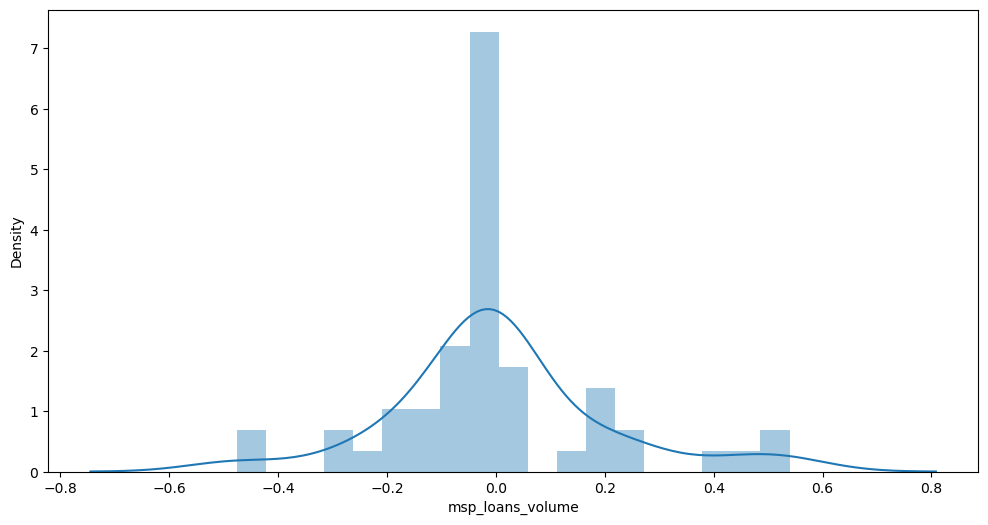

In [201]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.distplot(trn_transform)
plt.show()

# Обучение модели

In [202]:
model = ARIMA(trn_transform, order=(1,1,1))
model_fit = model.fit()
model_fit.aic

-11.400052259114979

In [203]:
model_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       msp_loans_volume   No. Observations:                   54
Model:                 ARIMA(1, 1, 1)   Log Likelihood                   8.700
Date:                Thu, 27 Jun 2024   AIC                            -11.400
Time:                        19:51:51   BIC                             -5.489
Sample:                    01-01-2019   HQIC                            -9.127
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1101      0.183     -0.601      0.548      -0.469       0.249
ma.L1         -0.9985      3.774     -0.265      0.791      -8.396       6.399
sigma2         0.0390      0.147      0.266      0.790      -0.248       0.326
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 5.36
Prob(Q):                              0.83   Prob(JB):                         0.07
Heteroskedasticity (H):               2.52   Skew:                             0.34
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

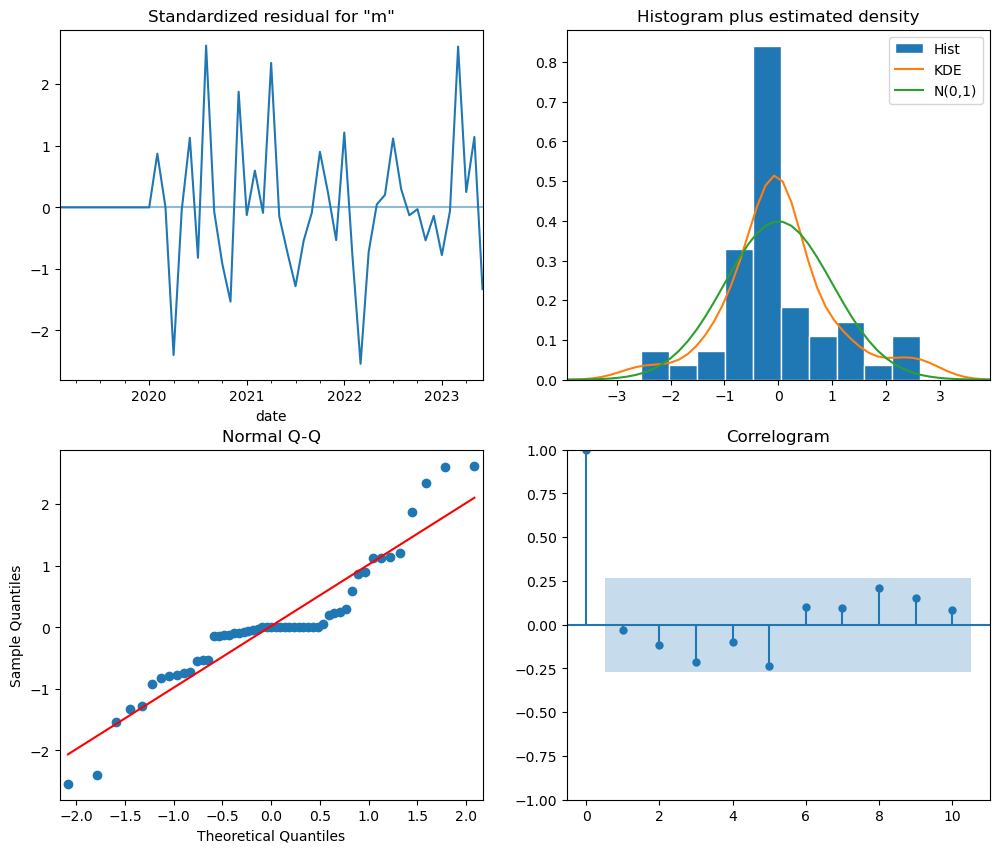

In [204]:
model_fit.plot_diagnostics(figsize=(12, 10))
plt.show()

# Прогноз

In [205]:
pred = model_fit.get_prediction(start=split_date.strftime('%Y-%m-%d'), end='2025-03-01', dynamic=False)
# The significance level for the confidence interval.
# The default alpha = .05 returns a 95% confidence interval.
pred_ci = pred.conf_int(alpha = 0.05) 
vol_diff_pred = pred.predicted_mean

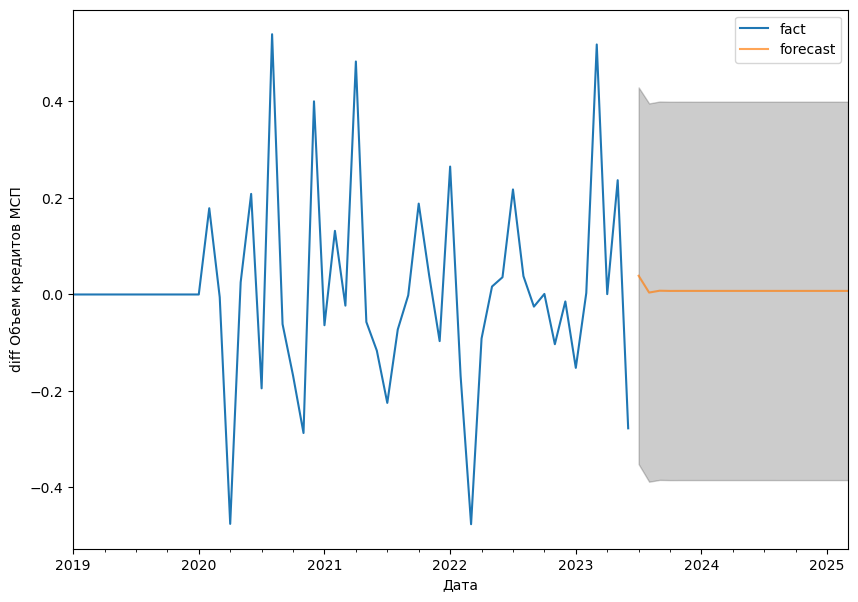

In [206]:
ax = trn_transform.plot(label='fact', figsize=(10, 7))
#ax.set_ylim([-1.5, 1.5])
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Дата')
ax.set_ylabel('diff Объем кредитов МСП')
plt.legend()
plt.show()

In [207]:
res = transformer_2.inverse_transform(vol_diff_pred)
res = transformer_1.inverse_transform(res)
res

2023-07-01    1.284091e+06
2023-08-01    1.319977e+06
2023-09-01    1.776246e+06
2023-10-01    1.575878e+06
2023-11-01    1.355690e+06
2023-12-01    2.222698e+06
2024-01-01    9.969585e+05
2024-02-01    1.212847e+06
2024-03-01    2.106022e+06
2024-04-01    1.737184e+06
2024-05-01    1.797523e+06
2024-06-01    2.356054e+06
2024-07-01    2.049126e+06
2024-08-01    2.122082e+06
2024-09-01    2.876878e+06
2024-10-01    2.571365e+06
2024-11-01    2.228558e+06
2024-12-01    3.681009e+06
2025-01-01    1.663360e+06
2025-02-01    2.038627e+06
2025-03-01    3.566296e+06
Freq: MS, Name: predicted_mean, dtype: float64

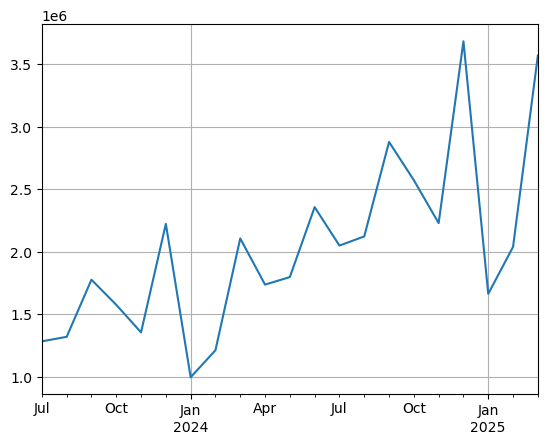

In [208]:
res.plot()
plt.grid(True)

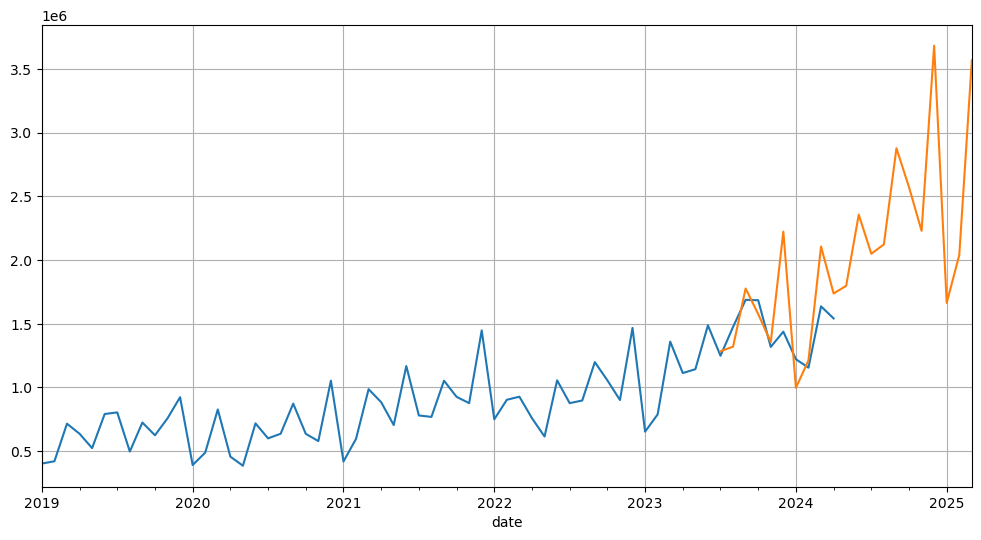

In [209]:
my_df = df.copy()
my_df = my_df[['date','msp_loans_volume']]
my_df['msp_loans_volume'] = my_df['msp_loans_volume'].astype(float)

my_df.set_index(keys='date', drop=True, inplace=True)
my_df = my_df.squeeze(axis=1)

plt.figure(figsize=(12, 6))
my_df.plot()
res.plot()
plt.grid(True)
plt.show()

In [210]:
test_pred = res[0:test_size]
mape(tst_ser.values, test_pred.values)

14.723788466890204

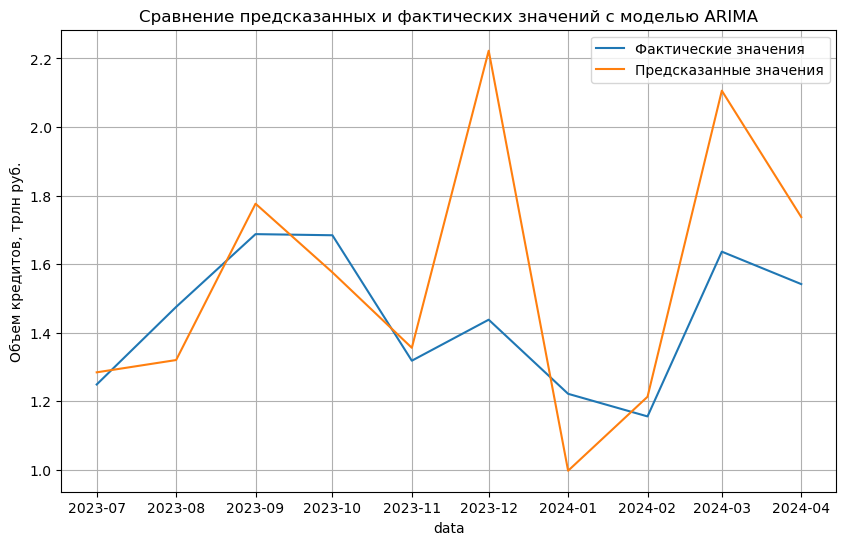

In [211]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(test_pred.index, tst_ser.values/ 1e6, label='Фактические значения')
plt.plot(test_pred.index, test_pred/ 1e6, label='Предсказанные значения')
plt.xlabel('data')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Сравнение предсказанных и фактических значений с моделью ARIMA')
plt.legend()
plt.grid(True)
plt.show()

## Изменим разделение на train и test

Модель обучалась на тренировочной выборке, составлявшей примерно 85% данных. Уменьшим тренировочную выборку и соответственно увеличим тестовую. Рассмотрим несколько вариантов.

Вариант 1 (80 к 20):

In [212]:
train_size = int(0.8 * len(df))
test_size = len(df) - train_size
print("train_size = ", train_size)
print("test_size = ", test_size)

train_size =  51
test_size =  13


In [213]:
split_date = df['date'].iloc[train_size]
split_date

Timestamp('2023-04-01 00:00:00')

In [214]:
# разделение данных на тестовые и тренировочные

train = df[df['date']<split_date]
test = df[df['date']>=split_date]

In [215]:
# Делаем из датафреймов серии

trn_ser = train.copy()
trn_ser.set_index(keys='date', drop=True, inplace=True)
trn_ser = trn_ser.squeeze(axis=1)

tst_ser = test.copy()
tst_ser.set_index(keys='date', drop=True, inplace=True)
tst_ser = tst_ser.squeeze(axis=1)

In [216]:
# Мы уже знаем, что исходные данные не стационарны, поэтому сразу применим к ним операции трансформации

transformer_1 = LogTransformer()
trn_transform = transformer_1.fit_transform(trn_ser) # логорифмируем
 
print(adfuller(trn_transform))# Данные не стационарны

transformer_2 = Differencer(lags=[1, 12])
trn_transform = transformer_2.fit_transform(trn_transform) # дифференцируем

print(adfuller(trn_transform))# Данные стационарны!

(-0.06254141871552682, 0.9530440835195174, 11, 39, {'1%': -3.610399601308181, '5%': -2.939108945868946, '10%': -2.6080629651545038}, -2.531169171942196)
(-5.505961058974946, 2.021659808749217e-06, 4, 46, {'1%': -3.5812576580093696, '5%': -2.9267849124681518, '10%': -2.6015409829867675}, -4.629549991756946)


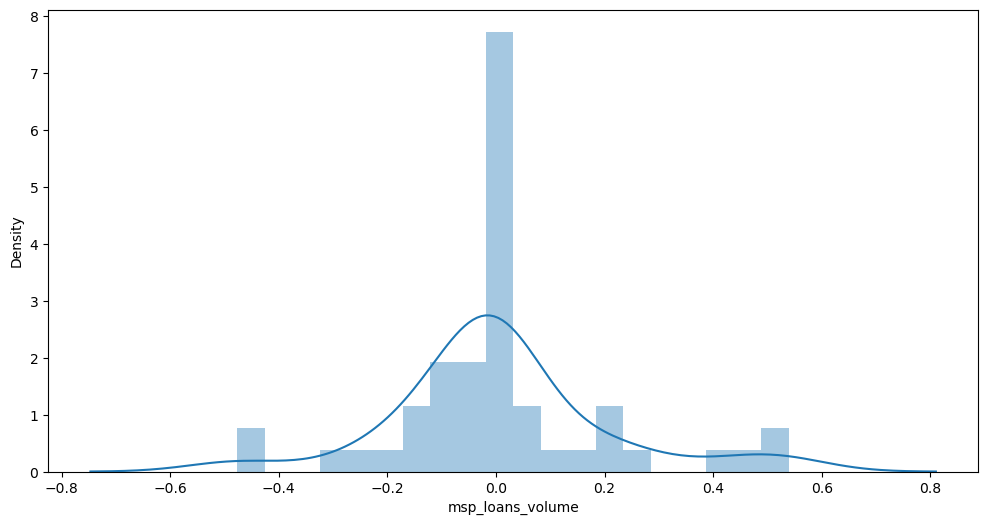

In [217]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.distplot(trn_transform)
plt.show()

In [218]:
# обучение модели

model = ARIMA(trn_transform, order=(1,1,1))
model_fit = model.fit()
model_fit.aic

-10.388980019009118

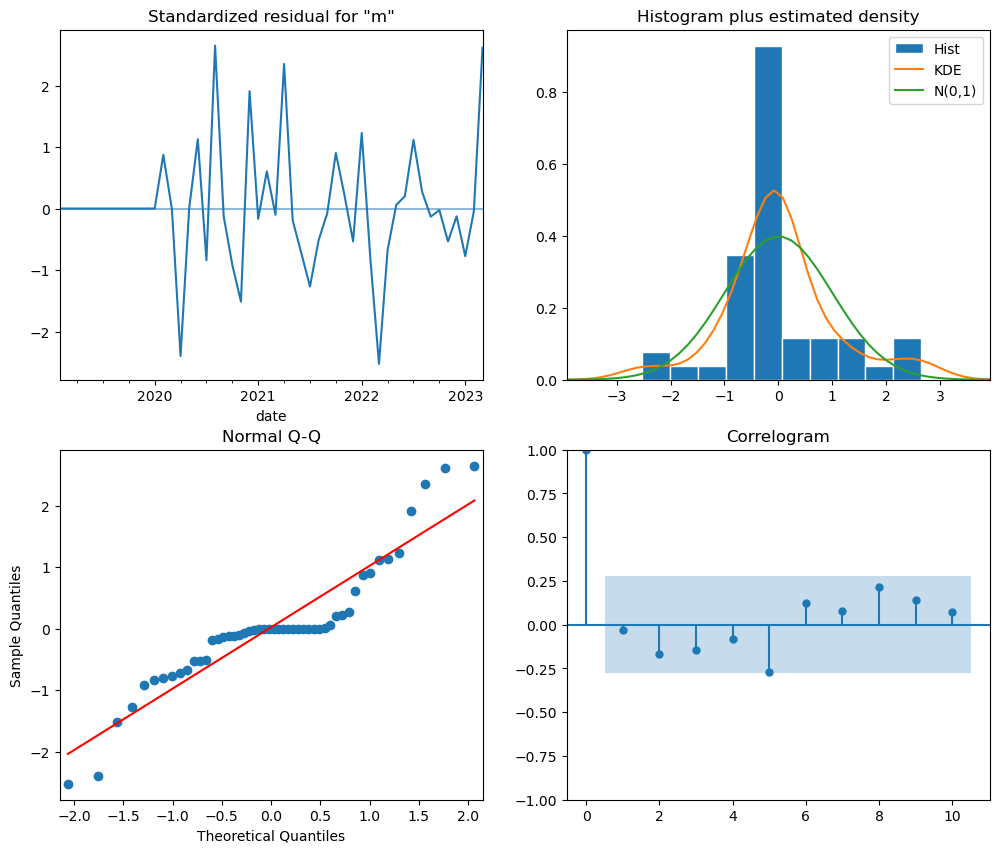

In [219]:
model_fit.plot_diagnostics(figsize=(12, 10))
plt.show()

In [220]:
# прогноз

pred = model_fit.get_prediction(start=split_date.strftime('%Y-%m-%d'), end='2025-03-01', dynamic=False)
pred_ci = pred.conf_int(alpha = 0.05) 
vol_diff_pred = pred.predicted_mean

res = transformer_2.inverse_transform(vol_diff_pred)
res = transformer_1.inverse_transform(res)
res

2023-04-01    1.070021e+06
2023-05-01    8.771748e+05
2023-06-01    1.516423e+06
2023-07-01    1.268561e+06
2023-08-01    1.308297e+06
2023-09-01    1.759566e+06
2023-10-01    1.560884e+06
2023-11-01    1.342560e+06
2023-12-01    2.200805e+06
2024-01-01    9.869734e+05
2024-02-01    1.200499e+06
2024-03-01    2.084232e+06
2024-04-01    1.652373e+06
2024-05-01    1.364432e+06
2024-06-01    2.375943e+06
2024-07-01    2.002061e+06
2024-08-01    2.079803e+06
2024-09-01    2.817550e+06
2024-10-01    2.517600e+06
2024-11-01    2.181222e+06
2024-12-01    3.601620e+06
2025-01-01    1.626942e+06
2025-02-01    1.993327e+06
2025-03-01    3.485884e+06
Freq: MS, Name: predicted_mean, dtype: float64

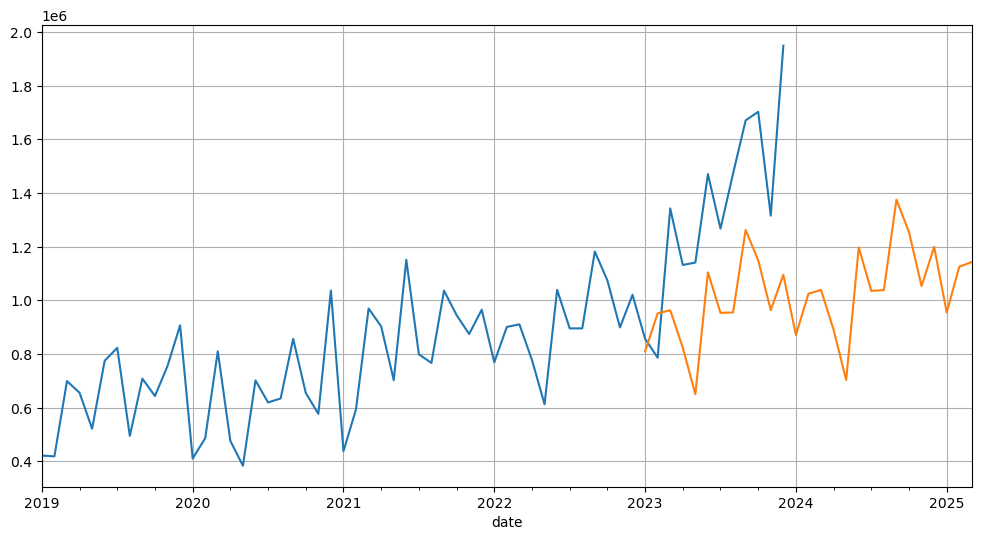

In [171]:
my_df = df.copy()
my_df = my_df[['date','msp_loans_volume']]
my_df['msp_loans_volume'] = my_df['msp_loans_volume'].astype(float)

my_df.set_index(keys='date', drop=True, inplace=True)
my_df = my_df.squeeze(axis=1)

plt.figure(figsize=(12, 6))
my_df.plot()
res.plot()
plt.grid(True)
plt.show()

In [221]:
test_pred = res[0:test_size]
mape(tst_ser.values, test_pred.values) 

12.783095048204132

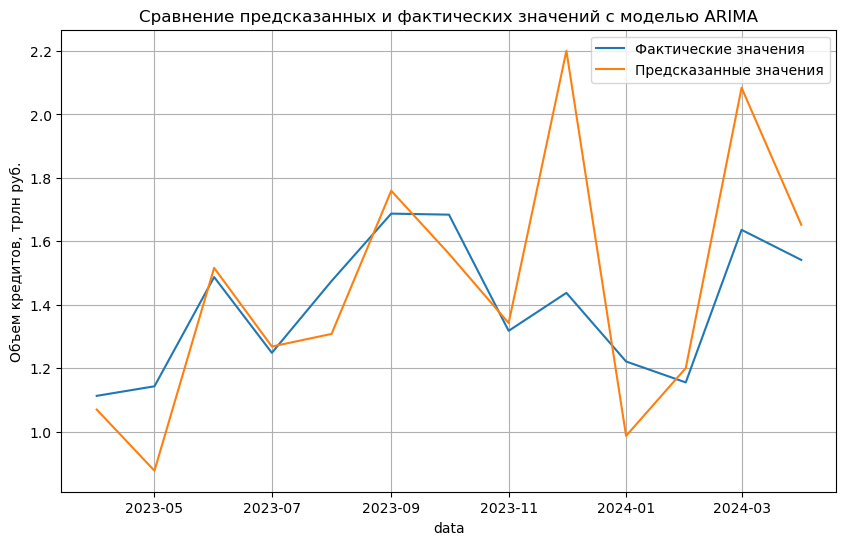

In [222]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(test_pred.index, tst_ser.values/ 1e6, label='Фактические значения')
plt.plot(test_pred.index, test_pred/ 1e6, label='Предсказанные значения')
plt.xlabel('data')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Сравнение предсказанных и фактических значений с моделью ARIMA')
plt.legend()
plt.grid(True)
plt.show()

Вариант 2 (75 к 25):

In [223]:
train_size = int(0.75 * len(df))
test_size = len(df) - train_size
print("train_size = ", train_size)
print("test_size = ", test_size)

train_size =  48
test_size =  16


In [224]:
split_date = df['date'].iloc[train_size]
split_date

Timestamp('2023-01-01 00:00:00')

In [225]:
# разделение данных на тестовые и тренировочные

train = df[df['date']<split_date]
test = df[df['date']>=split_date]

In [226]:
# Делаем из датафреймов серии

trn_ser = train.copy()
trn_ser.set_index(keys='date', drop=True, inplace=True)
trn_ser = trn_ser.squeeze(axis=1)

tst_ser = test.copy()
tst_ser.set_index(keys='date', drop=True, inplace=True)
tst_ser = tst_ser.squeeze(axis=1)

In [227]:
# Мы уже знаем, что исходные данные не стационарны, поэтому сразу применим к ним операции трансформации

transformer_1 = LogTransformer()
trn_transform = transformer_1.fit_transform(trn_ser) # логорифмируем
 
print(adfuller(trn_transform))# Данные не стационарны

transformer_2 = Differencer(lags=[1, 12])
trn_transform = transformer_2.fit_transform(trn_transform) # дифференцируем

print(adfuller(trn_transform))# Данные стационарны!

(-0.4521113647535664, 0.9010277617152707, 7, 40, {'1%': -3.6055648906249997, '5%': -2.937069375, '10%': -2.606985625}, 3.3746400206339757)
(-5.450983357731793, 2.644791332123214e-06, 4, 43, {'1%': -3.5925042342183704, '5%': -2.931549768951162, '10%': -2.60406594375338}, -8.143624288348079)


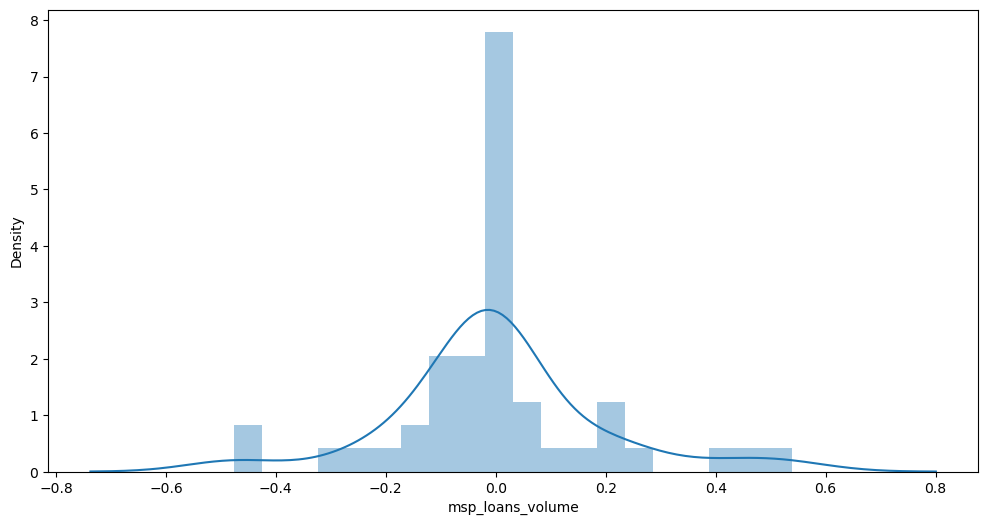

In [228]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.distplot(trn_transform)
plt.show()

In [229]:
# обучение модели

model = ARIMA(trn_transform, order=(1,1,1))
model_fit = model.fit()
model_fit.aic

-13.88890154459084

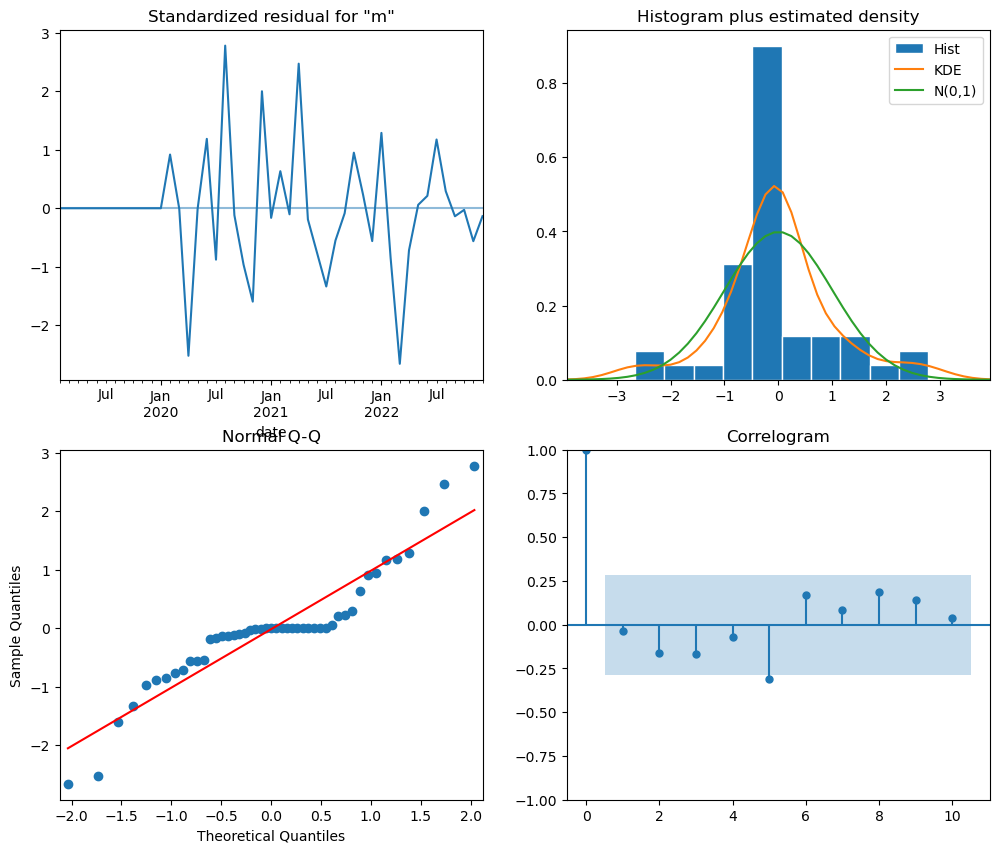

In [230]:
model_fit.plot_diagnostics(figsize=(12, 10))
plt.show()

In [231]:
# прогноз

pred = model_fit.get_prediction(start=split_date.strftime('%Y-%m-%d'), end='2025-03-01', dynamic=False)
pred_ci = pred.conf_int(alpha = 0.05) 
vol_diff_pred = pred.predicted_mean

res = transformer_2.inverse_transform(vol_diff_pred)
res = transformer_1.inverse_transform(res)
res

2023-01-01    7.622575e+05
2023-02-01    9.182948e+05
2023-03-01    9.436205e+05
2023-04-01    7.727504e+05
2023-05-01    6.268603e+05
2023-06-01    1.077225e+06
2023-07-01    8.954102e+05
2023-08-01    9.176084e+05
2023-09-01    1.226297e+06
2023-10-01    1.080936e+06
2023-11-01    9.238517e+05
2023-12-01    1.504837e+06
2024-01-01    7.825533e+05
2024-02-01    9.435906e+05
2024-03-01    9.704835e+05
2024-04-01    7.954618e+05
2024-05-01    6.458627e+05
2024-06-01    1.110875e+06
2024-07-01    9.242087e+05
2024-08-01    9.479703e+05
2024-09-01    1.268009e+06
2024-10-01    1.118706e+06
2024-11-01    9.569902e+05
2024-12-01    1.560213e+06
2025-01-01    8.120781e+05
2025-02-01    9.800693e+05
2025-03-01    1.008906e+06
Freq: MS, Name: predicted_mean, dtype: float64

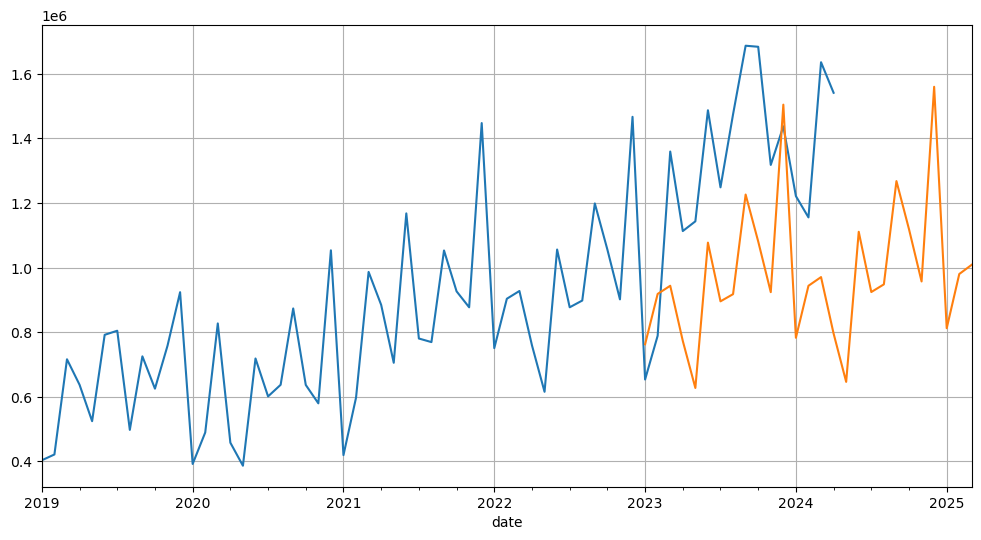

In [232]:
my_df = df.copy()
my_df = my_df[['date','msp_loans_volume']]
my_df['msp_loans_volume'] = my_df['msp_loans_volume'].astype(float)

my_df.set_index(keys='date', drop=True, inplace=True)
my_df = my_df.squeeze(axis=1)

plt.figure(figsize=(12, 6))
my_df.plot()
res.plot()
plt.grid(True)
plt.show()

In [233]:
test_pred = res[0:test_size]
mape(tst_ser.values, test_pred.values) 
# Все резко ухудшилось(((

29.6370481588733

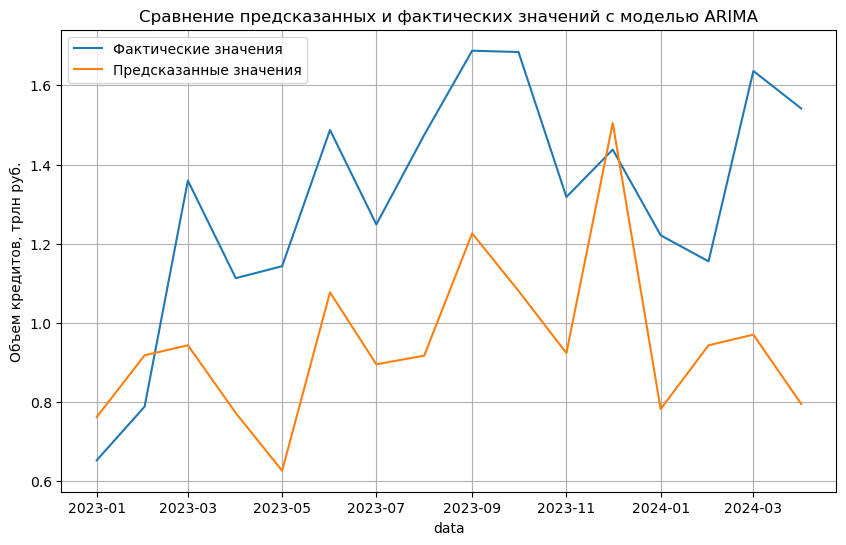

In [234]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(test_pred.index, tst_ser.values/ 1e6, label='Фактические значения')
plt.plot(test_pred.index, test_pred/ 1e6, label='Предсказанные значения')
plt.xlabel('data')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Сравнение предсказанных и фактических значений с моделью ARIMA')
plt.legend()
plt.grid(True)
plt.show()

Вариант 3 (split_date после 2023-01-01)

In [270]:
split_date = '2023-07'
n = df.index[df['date'] == split_date]
train_size = n[0]
test_size = len(df) - train_size
print("train_size = ", train_size)
print("test_size = ", test_size)

train_size =  54
test_size =  10


Если в коде выше установить split_date в промежутке [ 2023-01; 2023-03 ], то можем заметить сильное ухудшение качесва модели.

In [271]:
# разделение данных на тестовые и тренировочные

train = df[df['date']<split_date]
test = df[df['date']>=split_date]

In [272]:
# Делаем из датафреймов серии

trn_ser = train.copy()
trn_ser.set_index(keys='date', drop=True, inplace=True)
trn_ser = trn_ser.squeeze(axis=1)

tst_ser = test.copy()
tst_ser.set_index(keys='date', drop=True, inplace=True)
tst_ser = tst_ser.squeeze(axis=1)

In [273]:
# Мы уже знаем, что исходные данные не стационарны, поэтому сразу применим к ним операции трансформации

transformer_1 = LogTransformer()
trn_transform = transformer_1.fit_transform(trn_ser) # логорифмируем
 
print(adfuller(trn_transform))# Данные не стационарны

transformer_2 = Differencer(lags=[1, 12])
trn_transform = transformer_2.fit_transform(trn_transform) # дифференцируем

print(adfuller(trn_transform))# Данные стационарны!

(0.2836111339634128, 0.9765799537856866, 11, 42, {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}, -3.5773193750652013)
(-5.664660818170504, 9.210432964850806e-07, 4, 49, {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}, -5.634282326537857)


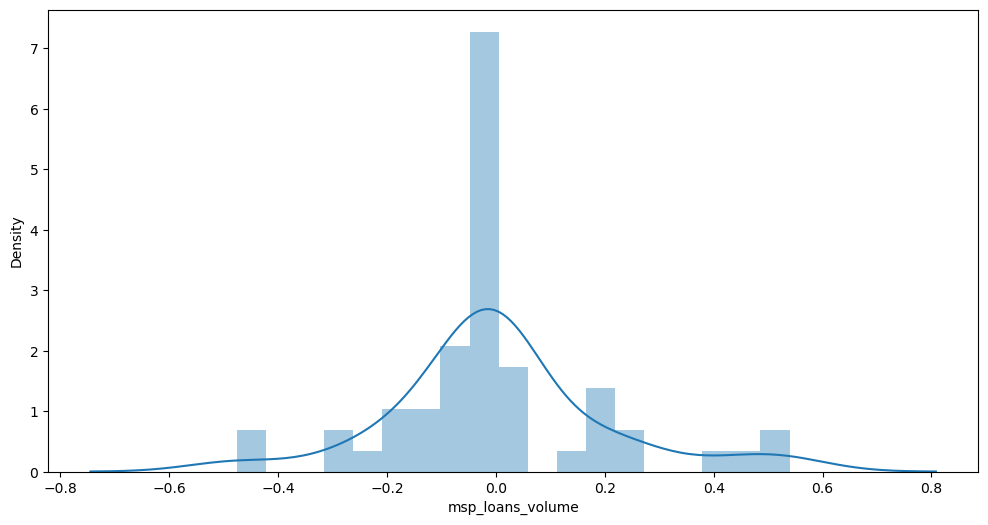

In [274]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.distplot(trn_transform)
plt.show()

In [275]:
# обучение модели

model = ARIMA(trn_transform, order=(1,1,1))
model_fit = model.fit()
model_fit.aic

-11.400052259114979

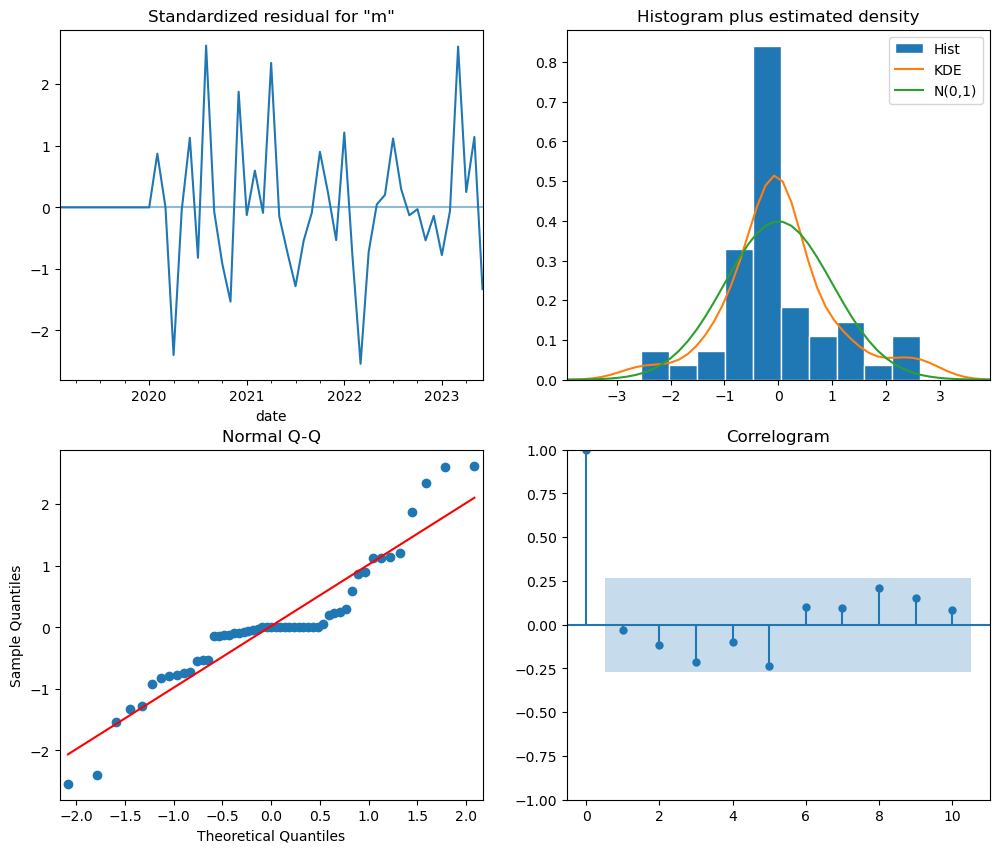

In [276]:
model_fit.plot_diagnostics(figsize=(12, 10))
plt.show()

In [277]:
# прогноз

pred = model_fit.get_prediction(start=split_date, end='2025-03-01', dynamic=False)
pred_ci = pred.conf_int(alpha = 0.05) 
vol_diff_pred = pred.predicted_mean

res = transformer_2.inverse_transform(vol_diff_pred)
res = transformer_1.inverse_transform(res)
res

2023-07-01    1.284091e+06
2023-08-01    1.319977e+06
2023-09-01    1.776246e+06
2023-10-01    1.575878e+06
2023-11-01    1.355690e+06
2023-12-01    2.222698e+06
2024-01-01    9.969585e+05
2024-02-01    1.212847e+06
2024-03-01    2.106022e+06
2024-04-01    1.737184e+06
2024-05-01    1.797523e+06
2024-06-01    2.356054e+06
2024-07-01    2.049126e+06
2024-08-01    2.122082e+06
2024-09-01    2.876878e+06
2024-10-01    2.571365e+06
2024-11-01    2.228558e+06
2024-12-01    3.681009e+06
2025-01-01    1.663360e+06
2025-02-01    2.038627e+06
2025-03-01    3.566296e+06
Freq: MS, Name: predicted_mean, dtype: float64

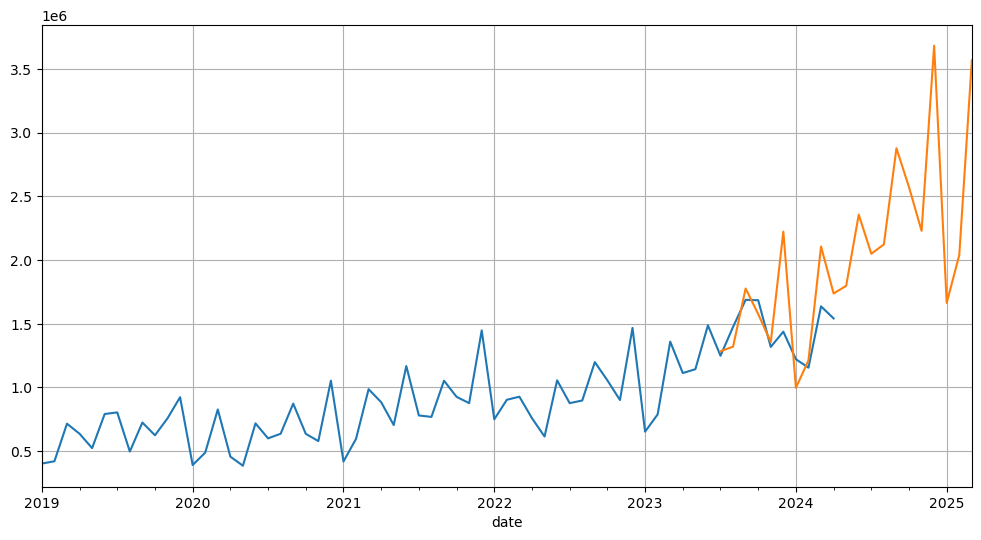

In [278]:
my_df = df.copy()
my_df = my_df[['date','msp_loans_volume']]
my_df['msp_loans_volume'] = my_df['msp_loans_volume'].astype(float)

my_df.set_index(keys='date', drop=True, inplace=True)
my_df = my_df.squeeze(axis=1)

plt.figure(figsize=(12, 6))
my_df.plot()
res.plot()
plt.grid(True)
plt.show()

In [279]:
test_pred = res[0:test_size]
mape(tst_ser.values, test_pred.values)

14.723788466890204

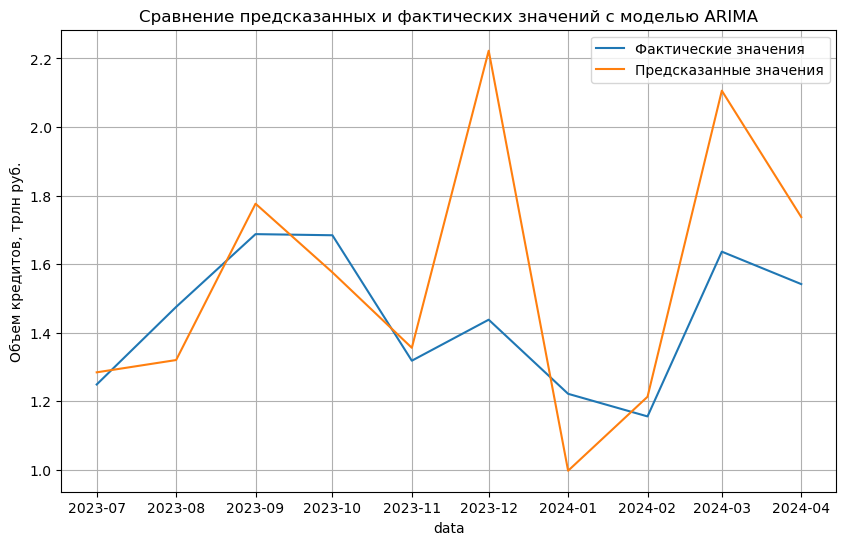

In [280]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(test_pred.index, tst_ser.values/ 1e6, label='Фактические значения')
plt.plot(test_pred.index, test_pred/ 1e6, label='Предсказанные значения')
plt.xlabel('data')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Сравнение предсказанных и фактических значений с моделью ARIMA')
plt.legend()
plt.grid(True)
plt.show()